# Product Quantization

In [1]:
!apt install libomp-dev
!pip install faiss-cpu --no-cache

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libomp-dev is already the newest version (1:14.0-55~exp2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [4]:
import numpy as np
import pandas as pd
from scipy.stats import kendalltau, spearmanr
import matplotlib
import matplotlib.pyplot as plt
import faiss
from search_approaches import PQ, ExactSearch
from utils import *

In [5]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

In [6]:
xb, xq, xt, gt = load_sift(name="siftsmall", dir="/content")
print("Base vectors shape: ", xb.shape)
print(f"Base vectors range: [{xb.min()}, {xb.max()}]")
print("Query vectors shape: ", xq.shape)
print("Ground truth shape: ", gt.shape)
print("Learn vectors shape: ", xt.shape)
print("Query example:\n", xq[0])

Base vectors shape:  (10000, 128)
Base vectors range: [0.0, 180.0]
Query vectors shape:  (100, 128)
Ground truth shape:  (100, 100)
Learn vectors shape:  (25000, 128)
Query example:
 [  1.   3.  11. 110.  62.  22.   4.   0.  43.  21.  22.  18.   6.  28.
  64.   9.  11.   1.   0.   0.   1.  40. 101.  21.  20.   2.   4.   2.
   2.   9.  18.  35.   1.   1.   7.  25. 108. 116.  63.   2.   0.   0.
  11.  74.  40. 101. 116.   3.  33.   1.   1.  11.  14.  18. 116. 116.
  68.  12.   5.   4.   2.   2.   9. 102.  17.   3.  10.  18.   8.  15.
  67.  63.  15.   0.  14. 116.  80.   0.   2.  22.  96.  37.  28.  88.
  43.   1.   4.  18. 116.  51.   5.  11.  32.  14.   8.  23.  44.  17.
  12.   9.   0.   0.  19.  37.  85.  18.  16. 104.  22.   6.   2.  26.
  12.  58.  67.  82.  25.  12.   2.   2.  25.  18.   8.   2.  19.  42.
  48.  11.]


In [7]:
tr_data = xb
queries = xq
sample_query = xq[0]
sample_query_snorm = np.sum(np.square(sample_query))

In [8]:
pq = faiss.ProductQuantizer(128, 8, 8)
pq.train(tr_data)

compressed_tr = pq.compute_codes(tr_data)
decompressed_tr = pq.decode(compressed_tr)

print("Reconstruction error on training data (NMSE): %.3f" % NMSE(tr_data, decompressed_tr))

Reconstruction error on training data (NMSE): 0.085


In [9]:
compressed_tr.shape # => M=8

(10000, 8)

In [10]:
np.max(np.unique(compressed_tr)) # => K=256

255

In [11]:
pq_faiss = faiss.IndexPQ(128, 8, 8)
pq_faiss.train(tr_data)
pq_faiss.add(tr_data)

pq = PQ(M=8, K=256, seed=RANDOM_SEED)
pq.train(tr_data)

es = ExactSearch(tr_data)

ranks_faiss_pq = np.zeros((queries.shape[0], tr_data.shape[0]), dtype=int)
ranks_mine_pq = np.zeros((queries.shape[0], tr_data.shape[0]), dtype=int)
ranks_exact = np.zeros((queries.shape[0], tr_data.shape[0]), dtype=int)

R = [1, 10, 100, 1000, 10000]
faiss_recall = np.zeros((len(queries), len(R)))
mine_recall = np.zeros((len(queries), len(R)))

for i, query in enumerate(queries):
  d_faiss, rank_faiss_pq = pq_faiss.search(query.reshape(1, -1), tr_data.shape[0])
  ranks_faiss_pq[i] = rank_faiss_pq[0]

  d_mine, rank_mine_pq = pq.search(query, subset=None, asym=True, correct=False)
  ranks_mine_pq[i] = rank_mine_pq

  d_exact, rank_exact = es.search(query)
  ranks_exact[i] = rank_exact

  for j, r in enumerate(R):
    faiss_recall[i][j] = rank_exact[0] in rank_faiss_pq[0][:r]
    mine_recall[i][j] = rank_exact[0] in rank_mine_pq[:r]

faiss_recall_mean = np.mean(faiss_recall, axis=0)
mine_recall_mean = np.mean(mine_recall, axis=0)

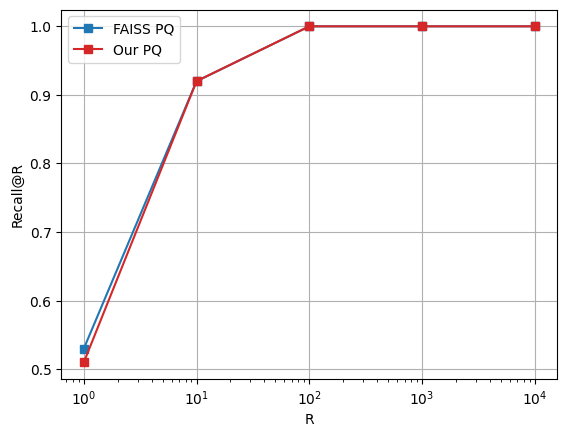

In [12]:
plt.plot(R, faiss_recall_mean, '-s', label="FAISS PQ", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, mine_recall_mean, '-s', label="Our PQ", color=matplotlib.colormaps["tab20"](6))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.legend()
plt.grid()

In [13]:
def sorted2rank(sorted):
  ranking = np.zeros(len(sorted))
  for i, el in enumerate(sorted):
      ranking[el] = i+1
  return ranking

In [14]:
kendalls_mine_pq = np.zeros(queries.shape[0])
spearmans_mine_pq = np.zeros(queries.shape[0])

kendalls_faiss_pq = np.zeros(queries.shape[0])
spearmans_faiss_pq = np.zeros(queries.shape[0])

for i in range(queries.shape[0]):
  sorted_exact = sorted2rank(ranks_exact[i])
  sorted_mine_pq = sorted2rank(ranks_mine_pq[i])
  sorted_faiss_pq = sorted2rank(ranks_faiss_pq[i])

  kendalls_mine_pq[i], _ = kendalltau(sorted_mine_pq, sorted_exact)
  spearmans_mine_pq[i], _ = spearmanr(sorted_mine_pq, sorted_exact)

  kendalls_faiss_pq[i], _ = kendalltau(sorted_faiss_pq, sorted_exact)
  spearmans_faiss_pq[i], _ = spearmanr(sorted_faiss_pq, sorted_exact)


pd.DataFrame({
    "Average kendall PQ": [np.mean(kendalls_mine_pq), np.mean(kendalls_faiss_pq)],
    "Average spearman PQ": [np.mean(spearmans_mine_pq), np.mean(spearmans_faiss_pq)],
}, index=["Our", "FAISS"])

,Average kendall PQ,Average spearman PQ
Our,0.845615,0.966192
FAISS,0.844752,0.965885


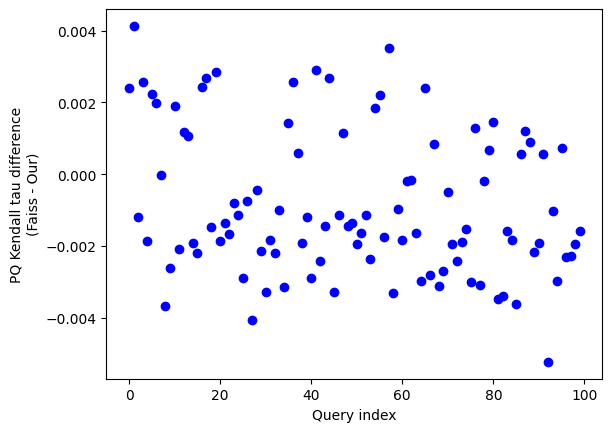

In [15]:
plt.plot(kendalls_faiss_pq-kendalls_mine_pq, 'o', color='blue')
plt.xlabel("Query index")
plt.ylabel("PQ Kendall tau difference\n(Faiss - Our)");